In [51]:
import xgboost as xgb
import shap
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)

from src.config import data_root
from sklearn.model_selection import train_test_split

shap.initjs()

In [52]:
issue_type_decode = {
  "Bug": 1,
  "Bug (Sub-task)": 2,
  "Sub-task": 3,
  "Improvement (Sub-task)": 4,
  "Prototype": 5,
  "New Feature or Improvement": 6,
  "Internal Improvement": 7,
  "Epic": 8
}
issue_priority_decode = {
  "Blocker": 1,
  "Minor": 2,
  "Major": 3,
  "Trivial": 4,
  "Critical": 5
}

In [53]:
# load the data
fname = f'{data_root}/prediction_data/encoded_model_data_development_filtered.csv'
data = pd.read_csv(fname)
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
features = list(data)[:-1]
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

In [54]:
# train
model = xgb.train(params={
        "objective": "reg:squarederror",
        "colsample_bytree": 0.3,
        "learning_rate": 0.05,
        "max_depth": 40,
        "alpha": 50,
        "reg_lambda": 30
    },
    dtrain=d_train,
    num_boost_round=500,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=50
)

[0]	test-rmse:6.84826
Will train until test-rmse hasn't improved in 50 rounds.
[100]	test-rmse:5.86886
Stopping. Best iteration:
[118]	test-rmse:5.86047



In [55]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X, y=y)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [56]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [57]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:])

In [58]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000,:])


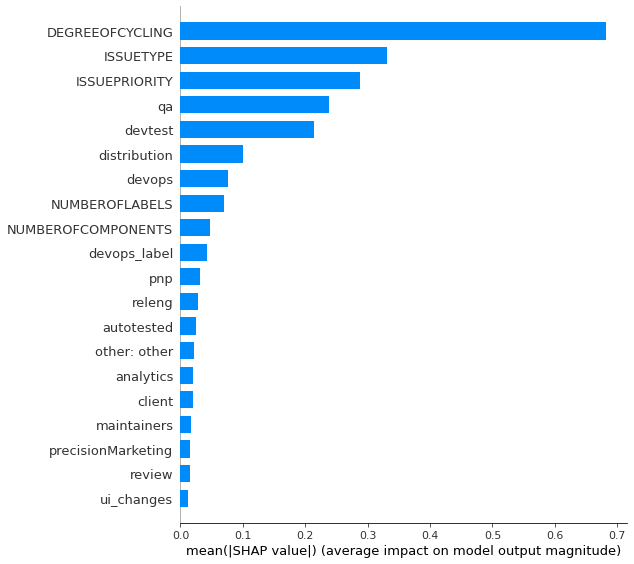

In [59]:
shap.summary_plot(shap_values, X, plot_type="bar")

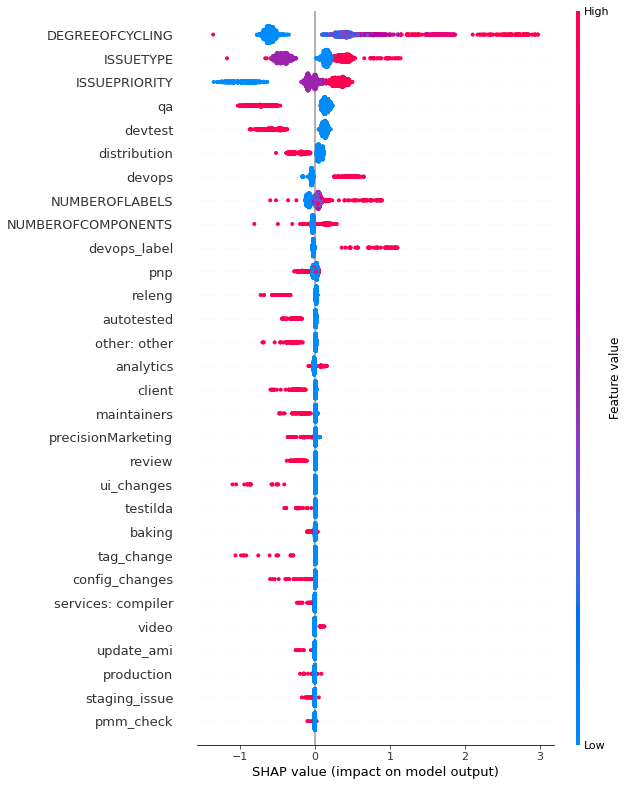

In [60]:
shap.summary_plot(shap_values, X, max_display=len(features))

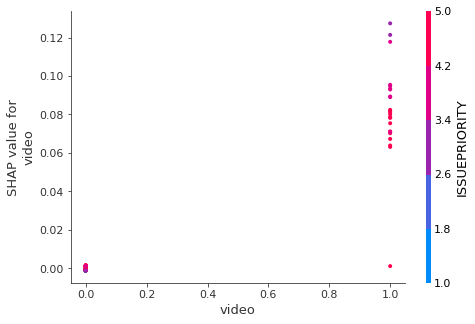

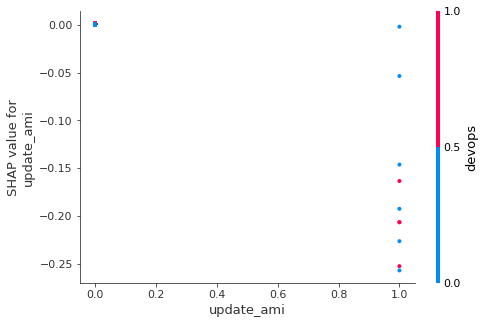

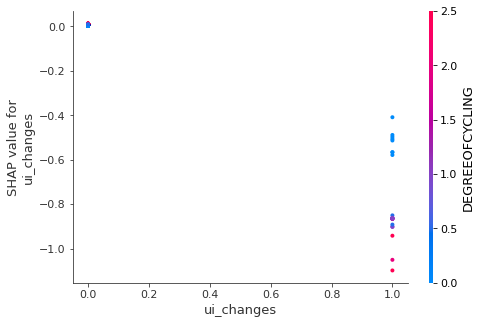

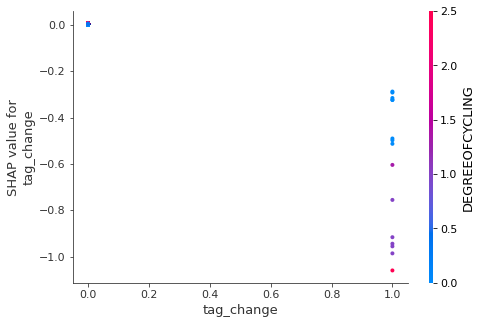

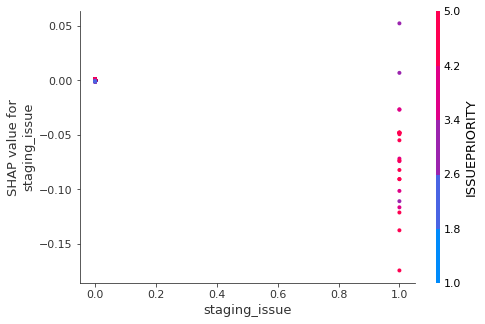

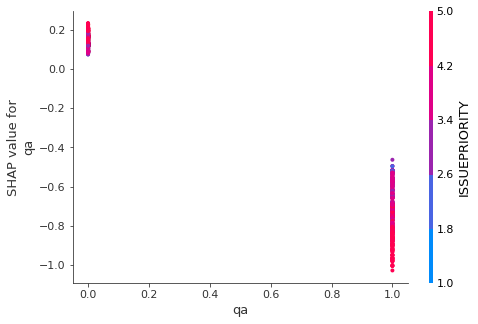

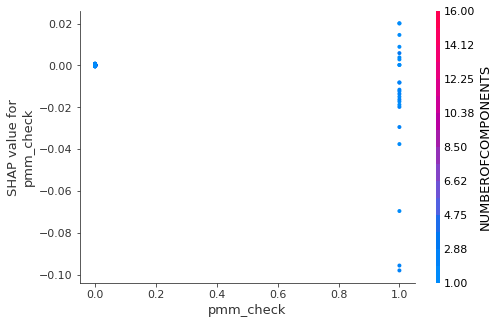

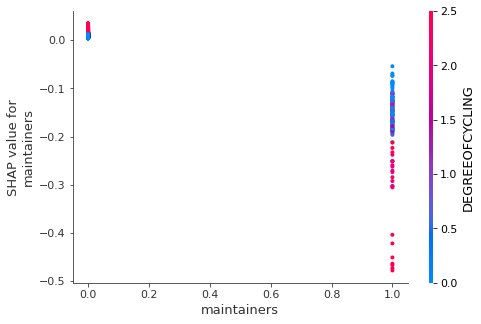

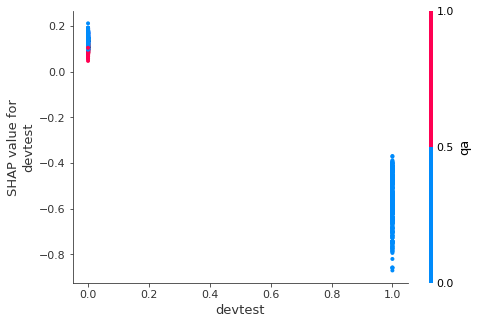

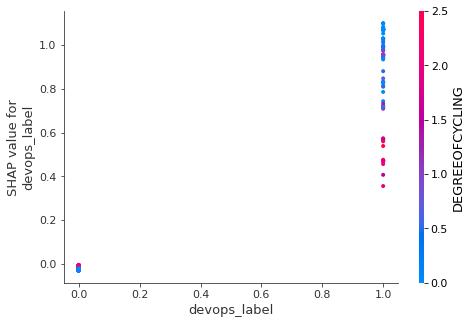

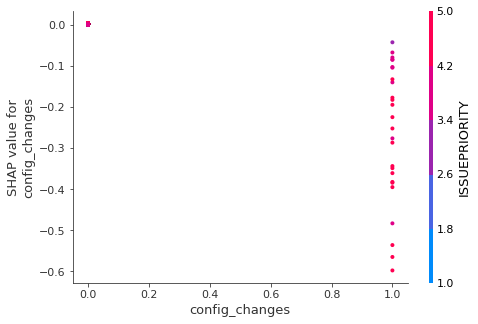

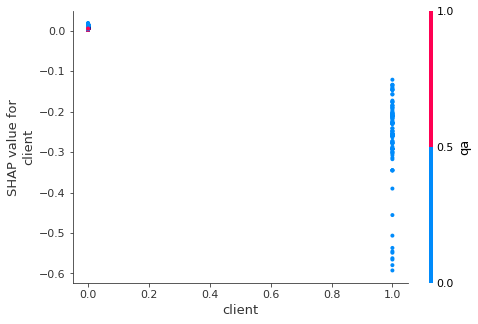

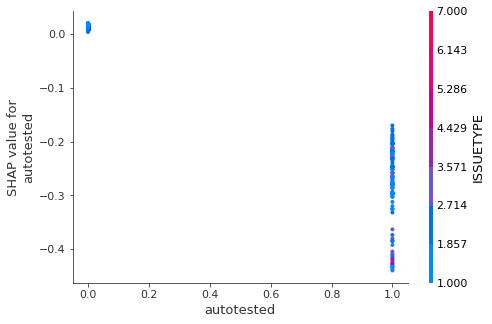

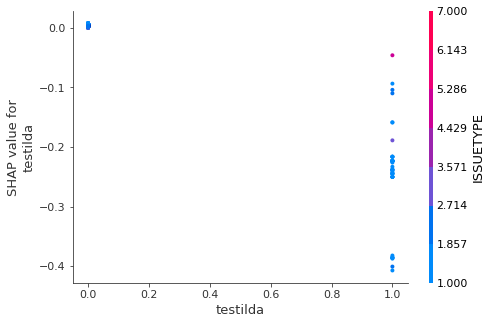

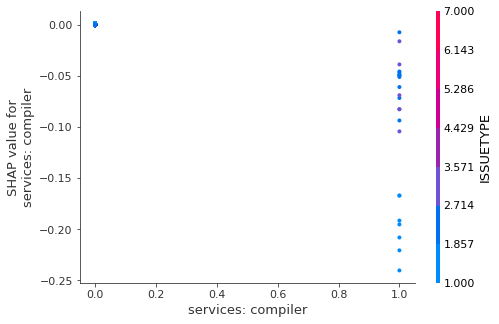

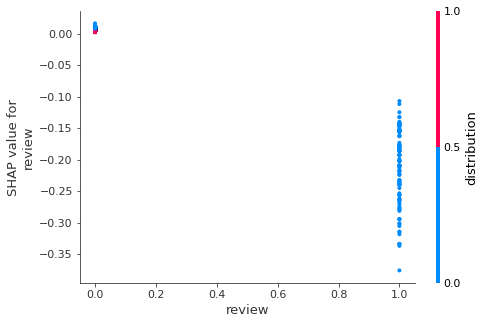

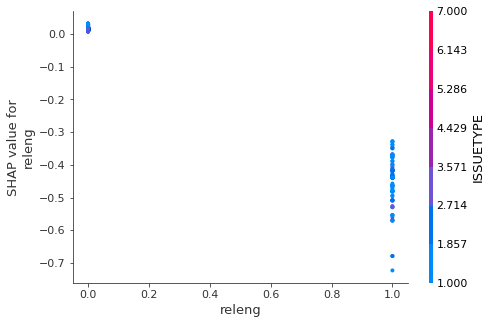

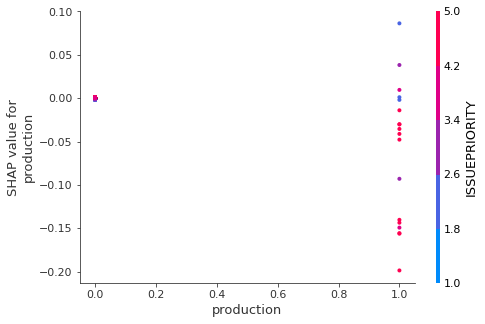

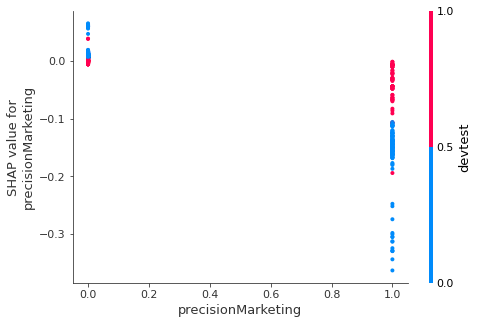

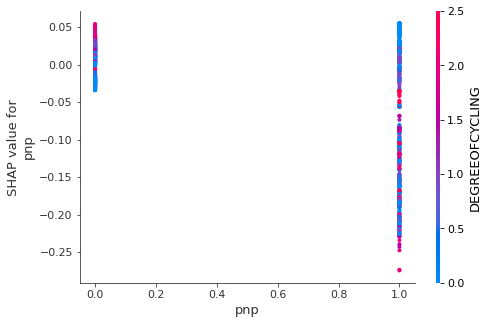

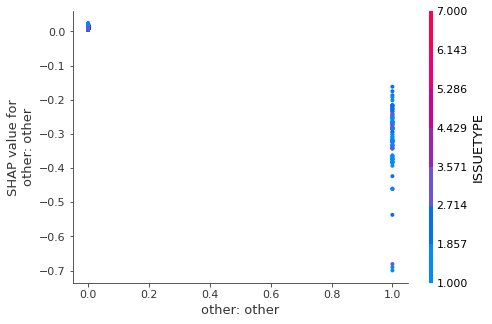

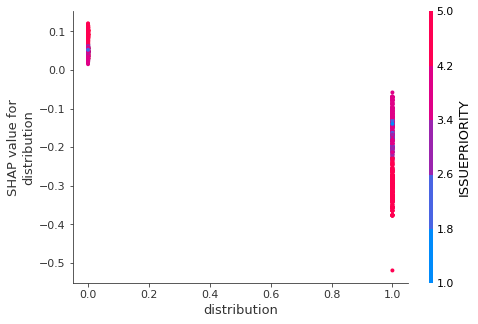

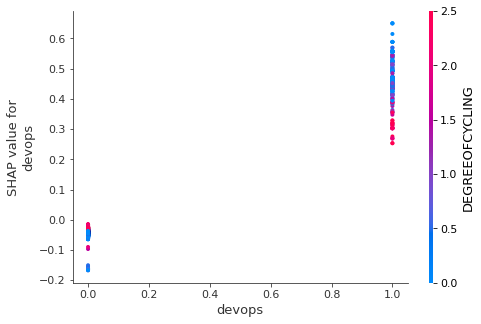

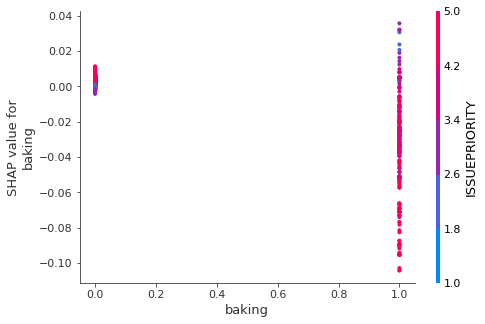

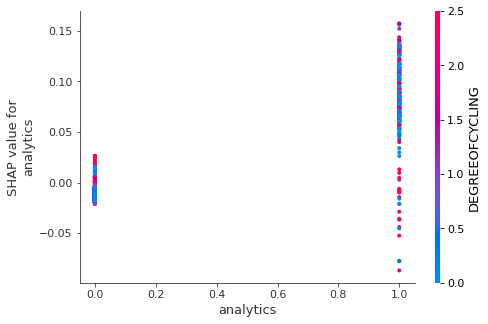

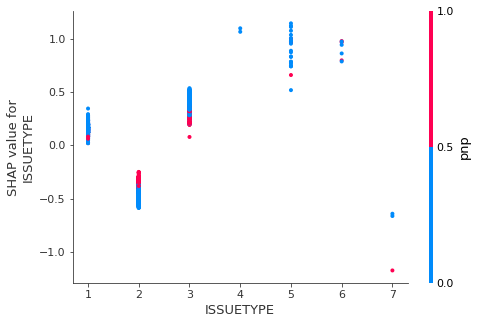

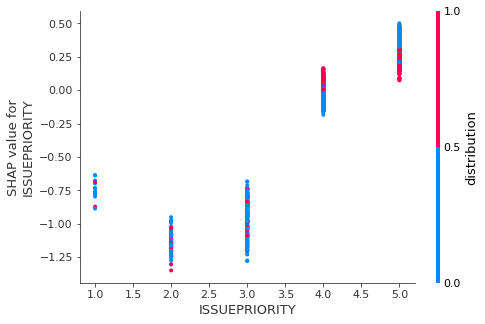

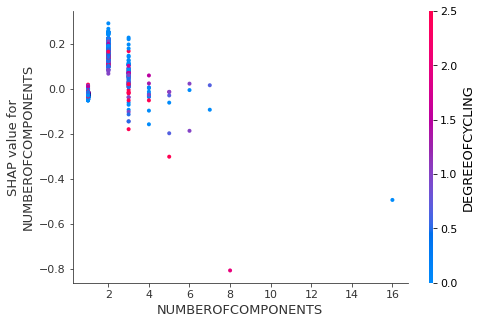

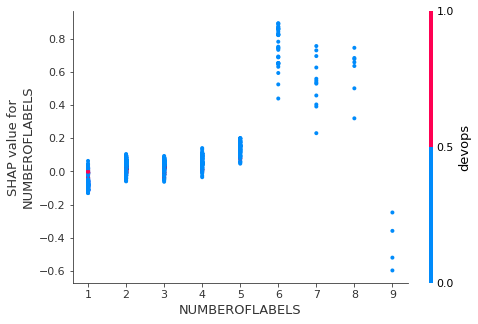

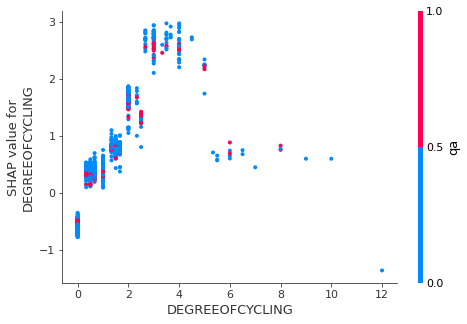

In [61]:
for name in list(X_train):
    shap.dependence_plot(name, shap_values, X)


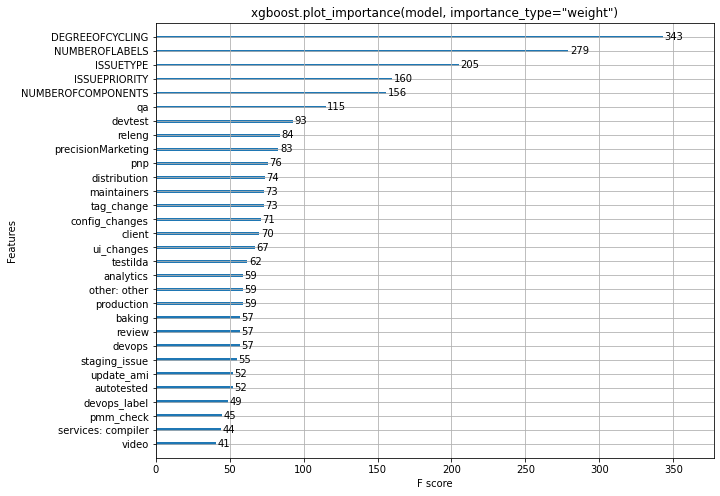

In [62]:
xgb.plot_importance(model)
plt.title('xgboost.plot_importance(model, importance_type="weight")')
plt.show()

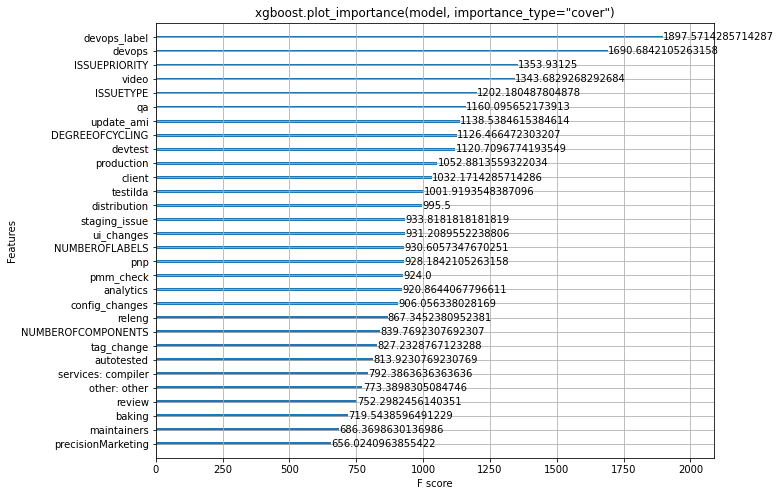

In [63]:
xgb.plot_importance(model, importance_type="cover")
plt.title('xgboost.plot_importance(model, importance_type="cover")')
plt.show()

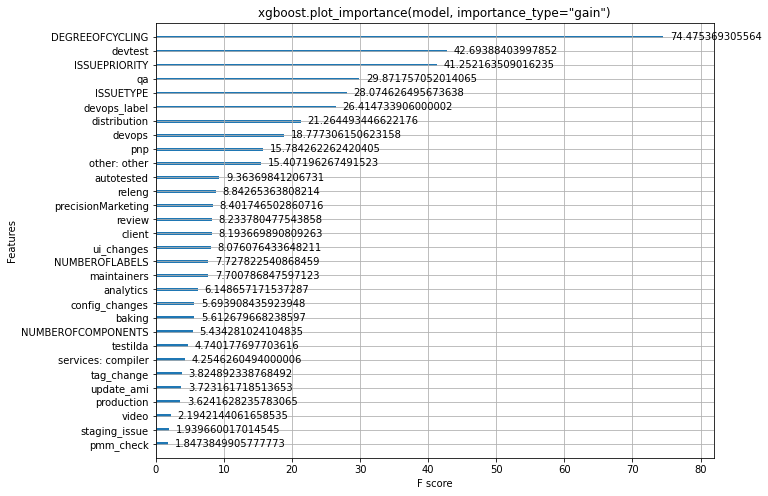

In [64]:
xgb.plot_importance(model, importance_type="gain")
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()


In [65]:
# explain the model's predictions using SHAP
# explainer = shap.KernelExplainer(model)
# shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])